# Load Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import datetime as dt 

from sklearn.linear_model import Ridge, Lasso, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import lightgbm as lgb

import optuna

In [2]:
# Experiment parameters 
TEMPORAL_FEATURES = True
LINEAR_FEATURES = False

INTERPOLATION= False
MISSING_INTERPOLATE = 'linear' #"linear" cubicspline polynomial

HOLIDAYS = True     
NEXT_HOLIDAY = True  

GDP = True

TRAFFIC_DATA = True

VAL_SPLIT = "2018-04-06" #"2017-12-31" 

#Models
MODEL = "Lightgbm" # "Lightgbm" Ridge

#lightgm only
OPTUNA= False 
NUM_TRIALS = 400 
BOOSTING = "gbdt" #dart

In [3]:
EPOCHS = 10000    
EARLY_STOPPING = 30

SCALER_NAME = "MinMaxScaler"  #None MinMax Standard RobustScaler
SCALER = MinMaxScaler()  #MinMaxScaler StandardScaler RobustScaler

In [4]:
sns.set_theme(style ="whitegrid")

# Load & Set Data

In [5]:
train = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Sales.csv")
traffic_preds = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/Predicted_Traffic_Values.csv")

#Note we are bringing in Actual and predicted historical values
traffic_actual = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/training_Traffic_Full.csv")

gdp = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/US_GDP.csv")
gdp.set_index('Year', inplace=True)

# holidays from https://data.world/sudipta/us-federal-holidays-2011-2020
if HOLIDAYS:
    US_holidays = pd.read_csv("/home/studio-lab-user/sagemaker-studiolab-notebooks/REPL Assignment/us-federal-holidays-2011-2020.csv") 
    US_holidays["Holiday"]= 1
    US_holidays["Date"] = pd.to_datetime(US_holidays["Date"])
    US_holidays.index = pd.to_datetime(US_holidays["Date"])

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6,7,8,9,10,11,14,15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
train["Date"] = pd.to_datetime(train["Date"])
traffic_preds["Date"] = pd.to_datetime(traffic_preds["Date"])
traffic_actual["Date"] = pd.to_datetime(traffic_actual["Date"])

train["Date"].max()

Timestamp('2018-05-06 19:00:00')

### Create Test Data
* Duplicate data of the last month of Traffic - then add 1 month to this 

In [7]:
lag_month = train["Date"].max() - pd.DateOffset(months=1)
test_time = train[train["Date"] >lag_month]["Date"] + pd.DateOffset(months=1)
test = pd.DataFrame(test_time, columns=["Date"])

In [8]:
# Set as index
train.index = train["Date"]
train.drop(["Date"],axis=1, inplace=True)

test.index = test["Date"]

test = test.drop(["Date"], axis =1)

traffic_preds.index = traffic_preds["Date"]
traffic_preds.drop(["Date"],axis=1, inplace=True)

traffic_actual.index = traffic_actual["Date"]
traffic_actual.drop(["Date"],axis=1, inplace=True)

# Missing Values 
As per the Exercise Description we have missing values as well as null values from concatenation. 
We have the basic mean, median and mode imputations however this wont work well for timeseries values. We should therefore use processes that can infer time series values such as: 
* Cubic Spline interpolation
* Linear interpolation 
* Supervised learning 

We will use experiment with Linear and Cubic Spline interpolation as using supervised learning will take too long for this exercise 
Spline vs Linear will be set using our experiment parameters 

**Note:** 
My initial assumption was that the 0 values are missing values. However this was later revised to be missing intervals. \
These intervals were resolved during the resampling process as they were set to 0 \
Have requested confirmation from REPL

In [9]:
# if INTERPOLATION: 
#     # Set all 0 values for ease of interpolation 
#     train["Value"].replace(0,np.NaN,inplace=True)
#     print("Null values PRIOR to interpolation:", train["Value"].isna().sum() )

#     #interpolate 
#     train.interpolate(method=MISSING_INTERPOLATE,inplace=True)
#     print("Null values AFTER interpolation:", train["Value"].isna().sum() )

# Resampling 

In [10]:
train = train.resample("H").sum()
test = test.resample("H").sum()

traffic_actual = traffic_actual.resample("H").sum()
traffic_preds = traffic_preds.resample("H").sum()

<AxesSubplot:ylabel='Value'>

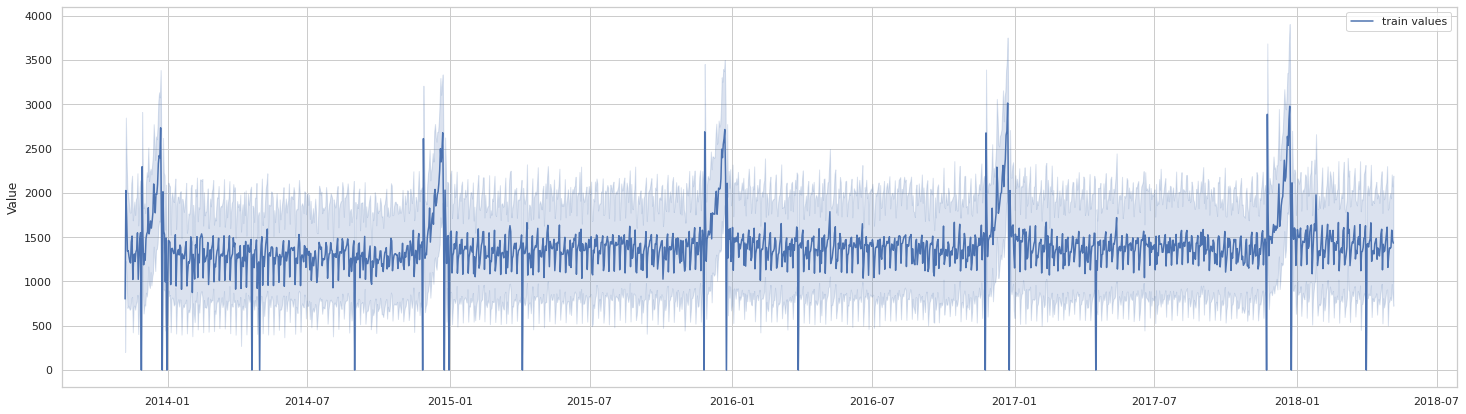

In [11]:
plt.figure(figsize=(25,7))
sns.lineplot(data = train, x = train.index.date, y = "Value", label = "train values", color = "b" )

In [12]:
train[train["Value"] ==0].count()

Value    20571
dtype: int64

### Merge Traffic data to Train 
Concatenate predicted Traffic data (from seperate notebook) to Sales data

In [13]:
if TRAFFIC_DATA:
    # Merge Full Traffic (historically predicted and Actual) to Train 
    train["Traffic"] = traffic_actual["Value"]
    print("Train Null Values after merge: ", train[ "Traffic"].isnull().sum() )
    
    # Merge Traffic predictions to Test 
    test["Traffic"] = traffic_preds["Value"]
    print("Test Null Values after merge: ", test[ "Traffic"].isnull().sum() )
else:
    del traffic_actual
    del traffic_preds

Train Null Values after merge:  0
Test Null Values after merge:  3


In [14]:
test.head()

,Traffic
Date,
2018-05-06 19:00:00,NaN
2018-05-06 20:00:00,NaN
2018-05-06 21:00:00,NaN
2018-05-06 22:00:00,0.0
2018-05-06 23:00:00,0.0


**Note during merge of Traffic data:** \
Due to time mismatches in Traffic vs Sales we are produced missing values in Test  \
As the values are few and are the intial values we can drop them 

In [15]:
print("\nTest: Null values Before drop:", test.isna().sum() )
test.dropna(inplace=True)
print("\nTest: Null values AFTER drop:", test.isna().sum() )


Test: Null values Before drop: Traffic    3
dtype: int64

Test: Null values AFTER drop: Traffic    0
dtype: int64


In [16]:
#for later visualization 
test_index = test.index

# Feature Extraction 

In [17]:
files = [train, test]

In [18]:
def temporal_extraction(df):
    #df["minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["month"] = df.index.month
    df["year"] = df.index.year
    
    df["is_month_start"] = df.index.is_month_start
    df["is_month_end"] = df.index.is_month_end
    
    df["Oct"] = df.index.month == 10
    df["Nov"] = df.index.month == 11
    df["Dec"] = df.index.month == 12
    df["Jan"] = df.index.month == 12
    
    df["weekofyear"] = df.index.isocalendar().week
    df["dayofweek"] = df.index.day_of_week
    
    #weekend = sat, sun 
    df["weekend_ind"] = df.index.day_of_week >=5
    df["friday"] = df.index.day_of_week ==4

    df["dayofyear"] = df.index.day_of_year
    df['inverse_dayofyear'] = 365 - df.index.dayofyear
    
    #2016 is a leap year 
    df.loc[df["year"] == 2016 , "inverse_dayofyear"] = df.loc[df["year"] == 2016 , "inverse_dayofyear"]+1
    
    #lets set quarters to a categorical feature as it I suspect this may better for boosting models to use categorical rather than numerical
    df['quarter'] = 'Q' + df.index.quarter.astype(str)
    df["daysinmonth"] = df.index.daysinmonth
    return df 

if TEMPORAL_FEATURES: 
    for file in files:
        temporal_extraction(file)

In [19]:
# Decompose any seasonal pattersn using sine and cosine functions (Fourier Analysis)
def linear_extractions(df):
    for k in range(1,20):
        df[f'sin{k}'] = np.sin(df.index.dayofyear / 365 * 2 * np.pi * k)
        df[f'cos{k}'] = np.cos(df.index.dayofyear / 365 * 2 * np.pi * k)
        
    df["sin_month"] = (np.sin(2 * np.pi * df.index.month/12))
    df['cos_month'] = (np.cos(2 * np.pi * df.index.month/12))
    df['sin_day'] = (np.sin(2 * np.pi * df.index.day/31))
    df['cos_day'] = (np.cos(2 * np.pi * df.index.day/31))
    df['sin_hour'] = (np.sin(2 * np.pi * df.index.hour/24))
    df['cos_hour'] = (np.cos(2 * np.pi * df.index.hour/24))
    df['sin_minute'] = (np.sin(2 * np.pi * df.index.minute/60))
    df['cos_minute'] = (np.cos(2 * np.pi * df.index.minute/60))
    
    return df 

if LINEAR_FEATURES:
    for file in files:
        linear_extractions(file)

In [20]:
def get_gdp(row):
    GDP = gdp[gdp.index ==row]["GPD_USD"].values[0]
    #print(GDP)
    return GDP

if GDP:
    for file in files:
        file["gdp"] = file["year"].apply(get_gdp ).astype("int64")
        file["gdp"] = file["gdp"]

In [21]:
def get_holidays(x):
    #print(x)
    if dt.date(x.loc['year'], x.loc['month'], x.loc['day']) in US_holidays.index.date:
        hol = 1
    else:
        hol =0
    return hol

if HOLIDAYS:
    print("Applying Holidays")
    for file in files:
        file["holiday"] = file.apply(lambda x: get_holidays(x) , axis =1 )

Applying Holidays


In [22]:
def next_Holiday(x):
    #print(x) 
    date = dt.date(x.loc['year'], x.loc['month'], x.loc['day'])
    

    try:
        nextDate = min([day for day in US_holidays.index if day >= date]).date()
    except ValueError:
        #no next holiday
        nextDate = date
    return (nextDate - date).days

if NEXT_HOLIDAY:
    print("Applying Next Holiday")
    for file in files:
        file['daysTillHoliday'] = file.apply(lambda x: next_Holiday(x), axis=1)

Applying Next Holiday


## Onehot Encoding 

In [23]:
categorical_feats = ["quarter"]

In [24]:
# Come back to this - drop first may no be needed

train = pd.get_dummies(train,columns= categorical_feats,drop_first=True)
test = pd.get_dummies(test,columns= categorical_feats, drop_first=False)

# As test only has 1 quarter
test["quarter_Q3"] = 0
test["quarter_Q4"] = 0

In [25]:
train.head()

,Value,Traffic,hour,day,month,year,is_month_start,is_month_end,Oct,Nov,...,friday,dayofyear,inverse_dayofyear,daysinmonth,gdp,holiday,daysTillHoliday,quarter_Q2,quarter_Q3,quarter_Q4
Date,,,,,,,,,,,,,,,,,,,,,
2013-11-07 13:00:00,3457,86.477108,13,7,11,2013,False,False,False,True,...,False,311,54,30,16784849196000,0,4,0,0,1
2013-11-07 14:00:00,2250,64.857831,14,7,11,2013,False,False,False,True,...,False,311,54,30,16784849196000,0,4,0,0,1
2013-11-07 15:00:00,0,0.000000,15,7,11,2013,False,False,False,True,...,False,311,54,30,16784849196000,0,4,0,0,1
2013-11-07 16:00:00,729,21.619277,16,7,11,2013,False,False,False,True,...,False,311,54,30,16784849196000,0,4,0,0,1
2013-11-07 17:00:00,0,0.000000,17,7,11,2013,False,False,False,True,...,False,311,54,30,16784849196000,0,4,0,0,1


# Split & Scale

In [26]:
train.sort_index(inplace=True)
test.sort_index(inplace=True)            
train = train.astype("float64")
test = test.astype("float64")

In [27]:
X = train.drop("Value", axis=1)
y= train["Value"]

In [28]:
def train_test_split(X, y):
    X_train =X[X.index<=VAL_SPLIT]
    X_test = X[X.index>VAL_SPLIT]
    
    y_train= y[y.index<=VAL_SPLIT]
    y_test = y[y.index>VAL_SPLIT]

    return X_train, X_test, y_train, y_test 

X_train, X_test, y_train, y_test = train_test_split(X,y)

### Scaling

In [29]:
def scale_data(X_train, X_test, test=None):
    scaler= SCALER
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    test = scaler.transform(test)
    
    return X_train, X_test, test

In [30]:
if SCALER_NAME !="None":
    print(f"Scaling with {SCALER_NAME}")
    X_train, X_test, test = scale_data(X_train, X_test, test)

Scaling with MinMaxScaler


In [31]:
X_train

array([[0.40750232, 0.56521739, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.30562674, 0.60869565, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.65217391, 0.2       , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.95652174, 0.13333333, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.13333333, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.16666667, ..., 1.        , 0.        ,
        0.        ]])

# OPTUNA (Lightgbm Hyperparameter Tuning)

In [32]:
def objective_lgb(trial):
    # 2. Suggest values of the hyperparameters using a trial object.
    params = {
        "num_threads": -1,
        "verbose" : -1,
        "boosting_type":"gbdt",
        "objective":trial.suggest_categorical("objective", ['poisson', 'mape', 'rmse']),
        "learning_rate": trial.suggest_uniform('learning_rate', 0.001, 0.10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),  #usually less than 2**max depth
        'max_bin': trial.suggest_int('max_bin', 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf":trial.suggest_int('min_data_in_leaf', 10,200)
    }
    
    metric_optuna = trial.suggest_categorical("metric", ['poisson', 'mape', 'rmse',])
    
    params["metric"] = metric_optuna
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    test_data =lgb.Dataset(X_test,label=y_test )

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, metric= metric_optuna)
    
    ## CREATE lightgbm model
    model = lgb.train(params=params,
                      train_set= train_data, 
                      num_boost_round= EPOCHS,
                      valid_sets= [test_data], 
                      callbacks=[lgb.early_stopping(EARLY_STOPPING),
                                 pruning_callback
                                ]
                     )

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    return np.sqrt(mse)

In [33]:
if OPTUNA:
    print("RUNNINING OPTUNA LIGHTGBM")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective_lgb, n_trials=NUM_TRIALS)
    trial = study.best_trial

In [34]:
if OPTUNA:
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial num :",trial.number)
    print(" RMSE Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

# Models

In [35]:
if OPTUNA: 
    print("Using Optuna params")
    lgb_params = trial.params

else:
    lgb_params= {
        'objective': 'rmse',
        'learning_rate': 0.09466758732298168,
        'lambda_l1': 1.392780799133831e-07,
        'lambda_l2': 3.2682758552035847e-06,
        'num_leaves': 38,
        'max_bin': 39,
        'max_depth': 6,
        'min_data_in_leaf': 181,
        'metric': 'poisson'}

##### Lightgbm

In [36]:
def fit_model_lgb(X_train,y_train,X_test,y_test):
    
    train_data = lgb.Dataset(X_train, label=y_train,)
    test_data =lgb.Dataset(X_test,label=y_test )

    ## CREATE lightgbm model
    model = lgb.train(params=lgb_params,
                      train_set= train_data, 
                      num_boost_round= EPOCHS,
                      valid_sets= [test_data], 
                      callbacks=[lgb.early_stopping(EARLY_STOPPING)],
                     )

    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    #Predict test 
    test_preds = model.predict(test)
    
    return y_pred,test_preds,  model

##### Ridge

In [37]:
def fit_model_ridge(X_train,y_train,X_test,y_test):

    ## CREATE lightgbm model
    model = Ridge(alpha = 0.51, tol=0.0000000001,)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred =np.clip(y_pred,0,max(y_pred))
    
    mse = mean_squared_error(y_test,y_pred )
    print("RMSE", np.sqrt(mse))
    print("R2", r2_score(y_test, y_pred))
    
    #Predict test 
    test_preds = model.predict(test)
    
    return y_pred,test_preds,  model

In [38]:
if MODEL == "Lightgbm":
    print("Running Lightgbm ")
    y_pred, test_preds, model = fit_model_lgb(X_train, y_train, X_test, y_test)
if MODEL == "Ridge": 
    print("Running Ridge")
    y_pred, test_preds, model = fit_model_ridge(X_train, y_train, X_test, y_test)

Running Lightgbm 
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 307
[LightGBM] [Info] Number of data points in the train set: 38652, number of used features: 24
[LightGBM] [Info] Start training from score 1388.411725
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

# Post Processing 

In [39]:
# As This is Sales we will round the values as well as clip any negative values 
test_preds = test_preds.round()
test_preds = np.clip(test_preds, 0, max(test_preds))
test_preds[:10]

array([ 4.,  4.,  8.,  8.,  8.,  8.,  8.,  8.,  8., 11.])

# Submission and visualization 

In [40]:
sales_preds = pd.DataFrame(data= test_preds,columns=["Value"], index=test_index)

#Save Submission 
if MODEL == "Lightgbm":
    sales_preds.to_csv("./Submission/Predicted_Sales_lgb.csv")
if MODEL == "Ridge": 
    sales_preds.to_csv("./Submission/Predicted_Sales_ridge.csv")

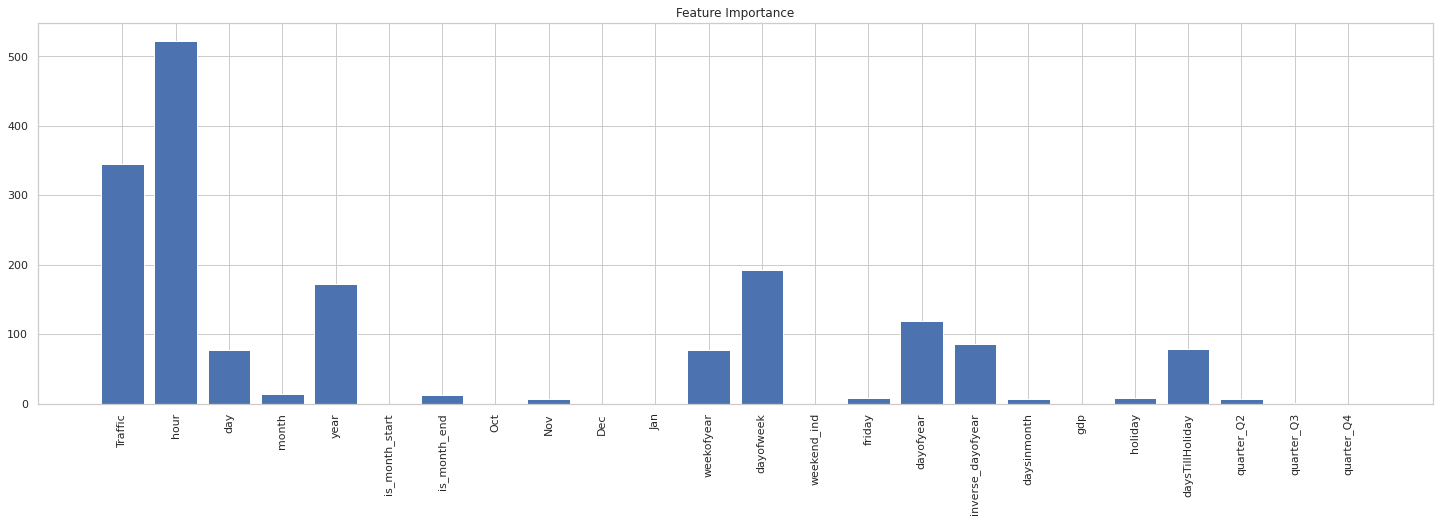

In [41]:
if MODEL == "Lightgbm": 
    plt.figure(figsize=(25,7))
    plt.bar(x = X.columns ,height=model.feature_importance())
    plt.xticks(rotation=90)
    plt.title("Feature Importance")

    plt.show()

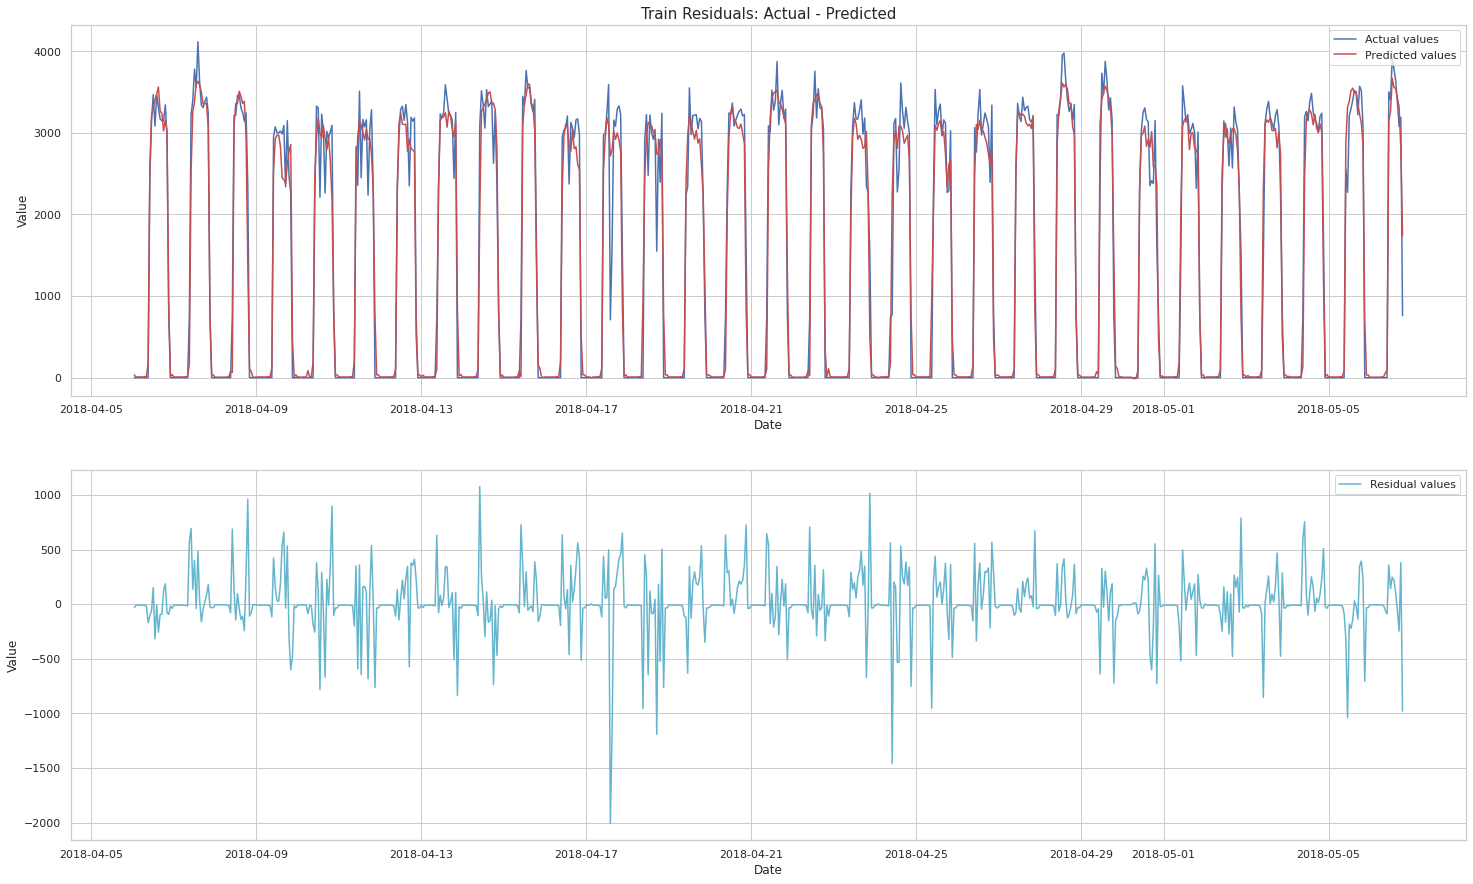

In [42]:
fig,ax = plt.subplots(2,1, figsize=(25,15))

sns.lineplot(ax= ax[0], x = y_test.index, y =y_test, label = "Actual values", color = "b" )
sns.lineplot(ax= ax[0], x = y_test.index, y =y_pred, label = "Predicted values", color = "r" )
ax[0].set_title('Train Data: Actual vs Predicted',fontdict={'fontsize': 15}) 

diff_sales = y_test - y_pred
sns.lineplot(ax= ax[1], x = y_test.index, y =diff_sales, label = "Residual values", color = "c" )
ax[0].set_title('Train Residuals: Actual - Predicted',fontdict={'fontsize': 15}) 

plt.show()

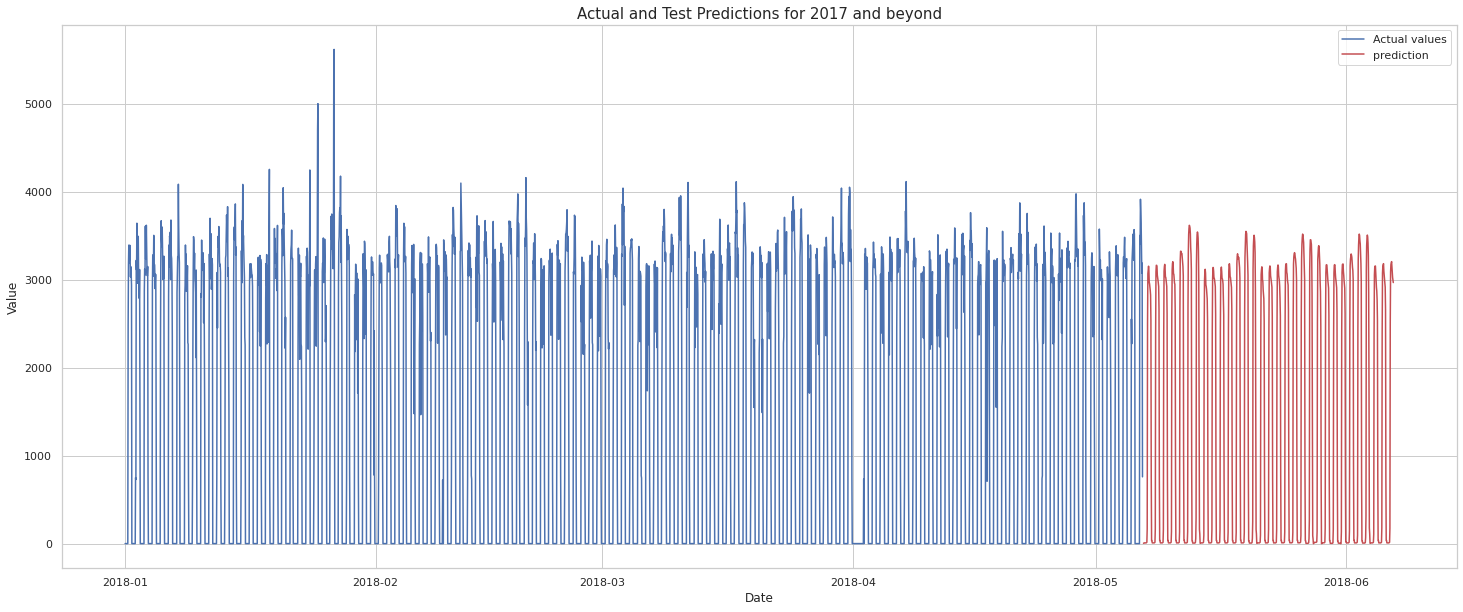

In [43]:
plt.figure(figsize=(25,10))

sns.lineplot(data = train[train.index > pd.to_datetime( "2018-01-01") ] ["Value"], label = "Actual values", color = "b" )
sns.lineplot(x = test_index, y =test_preds, label = "prediction", color = "r" )

plt.title('Actual and Test Predictions for 2017 and beyond',fontdict={'fontsize': 15}) 
plt.show()

# Results / Runs

## 1. Lightgbm 
##### Baseline - no linear features, no GDP, no scaling
*  No Traffic -RMSE 299.13857480573034 | R2 0.9621324104085449
* **Traffic added** - RMSE 298.1135895233149 | R2 0.9623914691091754

##### Scaling (only temporal features)
* RobustScaler---------------------------- RMSE 303.99776596223 | R2 0.9608921802090679
* Standard Scaler------------------------- RMSE 314.79583896846503 | R2 0.9580646002338656
* **MinMax Scaler**----------------------- RMSE 299.6692789218274 | R2 0.9619979288403075

##### Features (MinMax Scaler) 
* All features + GDP + holidays---------------- RMSE 315.83509851692025 | R2 0.9577872540994787
* Removed lin features -------------------------RMSE 275.9194329700153 | R2 0.967782829245871


## 2.Ridge 
* No scaling ------------------ RMSE 619.2594404738962 | R2 0.8377188437996465
* Standard Scaler---------------RMSE 620.7011030976055 | R2 0.836962369241826
* **MinMax Scaler**-------------RMSE 621.6494152108614 | R2 0.8364638082854559

##### Clip Values
* ------------------------RMSE 608.2028797001061 | R2 0.8434620055499779